In [1]:
# Brain tumor dataset
# https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/code?resource=download

State_dict() in pytorch

In [1]:
### what is state_dict
## the storable variables in 
## Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored
## Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) 
# and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict.

import torch
import torch.nn as nn
import torch.optim as optim #inclide optimization algorithms in torch
class Net(nn.Module): #keras.layers is like nn.module
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) ## number of input chan(RGB), number of output channel(number of filters or kernels), kernel 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #fully connected
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x): #like 'call' method
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  ## flatten in keras -1 is number of samples and should not be changed
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
 #Stochastic Gradient Descent (optionally with momentum)
 #lr --> learning rate

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
# Print model's state_dict
dict1 = net.state_dict() # '.state_dic' is like '.weight' in keras, in pytorch weights are stored in dic
print(dict1.keys())
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", dict1[param_tensor].size())

print()



odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])



In [3]:
print(dict1['conv1.weight'].size())

torch.Size([6, 3, 5, 5])


In [4]:
# .state_dic show us the parameters either for net(model) or for optimizer
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


Model and plot saving

In [5]:
import torch
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({ ##  A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"./outputs/model.pth")
    """A file with a . pth extension typically contains a serialized PyTorch state
    dictionary. A PyTorch state dictionary is a Python dictionary that contains the
    state of a PyTorch model, including the model's weights, biases, and other parameters."""


def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"./outputs/accuracy.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"./outputs/loss.png")

Load our MRI tomur and notomur dataset

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Required constants.
TRAIN_DIR = './data/Training'  # data\Training 
VALID_DIR = './data/Validation'
IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 32 
NUM_WORKERS = 4 # Number of parallel processes for data preparation. #how much using GPU

Preprocessing our MRI data
we add noise and transform train data to not be dependent on validate data and the right features be learned

In [7]:
# Training transforms
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225] #mean and std imagenet dataset which our model is pretrained by them 
            )
    ])
    return train_transform


# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform


# RandomHorizontalFlip: Flipping the image horizontally randomly.
# RandomVerticalFlip: Randomly flipping the image vertically.
# GaussianBlur: Applying Gaussian blurring to the image.
# RandomAdjustSharpness: Changing the sharpness of the image randomly.
# do not apply color or contrast transform as it may affect adversly on proper train learning


In [8]:
def get_datasets():
    """
    Function to prepare the Datasets.
    Returns the training and validation datasets along 
    with the class names.
    """
    #data belongs to defferent classes should be in seperate folders with a proper name that are exact the same in train, val, and test folder
    dataset_train = datasets.ImageFolder(
        TRAIN_DIR, 
        transform=(get_train_transform(IMAGE_SIZE))
    )
    dataset_valid = datasets.ImageFolder(
        VALID_DIR, 
        transform=(get_valid_transform(IMAGE_SIZE))
    )
    return dataset_train, dataset_valid, dataset_train.classes #classes of dataset train detected from the name of folders




def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader 

# The get_datasets() function prepares the training and validation datasets and returns them along with the class names.

# The get_data_loaders() function takes in the datasets as parameters and prepares the training and validation data loaders.

## dataloder, train or validatation folder should consists of some folders. 
# Each folder is assumed a class and all the pics within the folder are labeled similarly.

In [14]:
print(dataset_train.classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [10]:
import torchvision.models as models
import torch.nn as nn
def build_model(pretrained=True, fine_tune=True, num_classes=10): #fine_tune=True means trainable is true
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True #trainable=True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [11]:
# Training function: in one epoch how train the model
def train(model, trainloader, optimizer, criterion):
    model.train()  # in contrast = model.eval()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(trainloader): #number of data is number  of mini_batches in each iteration working on a certain mini_bach
        counter += 1
        image, labels = data
        image = image.to(device) ## cpu or gpu
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1) #which class it is
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [12]:
# Validation function: in one epoch how validate model
#we dont use dropout in val state so its important to seperate train and validation process
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

The main code and using all the previaus defined Classes

In [13]:
dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)
# Learning_parameters. 
lr = 0.0001
epochs = 20
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")
model = build_model(
    pretrained=True,
    fine_tune=True, 
    num_classes=len(dataset_classes)
).to(device)


# Optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

print('TRAINING COMPLETE')
    


[INFO]: Number of training images: 5712
[INFO]: Number of validation images: 1307
[INFO]: Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Computation device: cpu
Learning rate: 0.0001
Epochs to train for: 20

[INFO]: Loading pre-trained weights


c:\Users\mashadservice.ir\.conda\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\mashadservice.ir\.conda\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\mashadservice.ir/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth
100.0%


[INFO]: Freezing hidden layers...
[INFO]: Epoch 1 of 20
Training
Validation
Training loss: 1.183, training acc: 55.357
Validation loss: 1.155, validation acc: 63.351
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


KeyboardInterrupt: 

In [ ]:
##HW: sometimes loss is lower but acc is higher why?? 

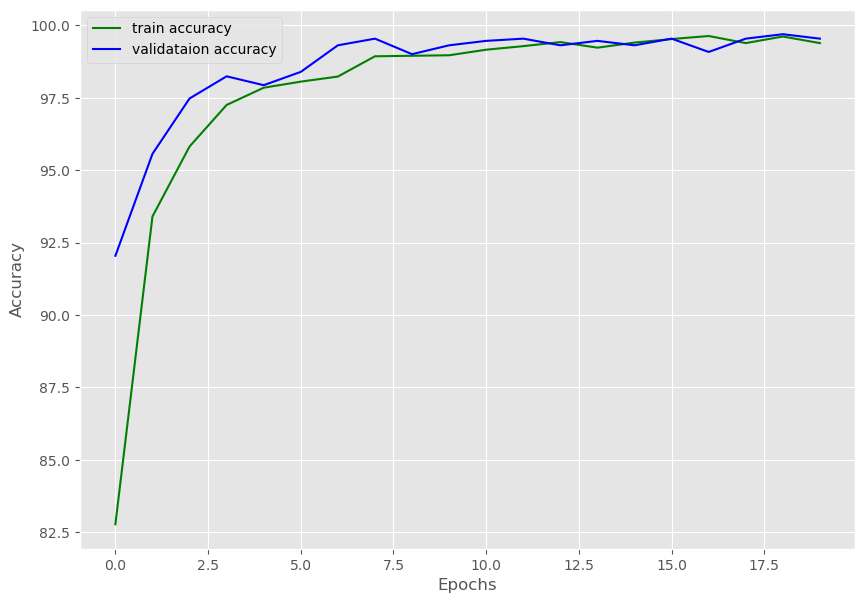

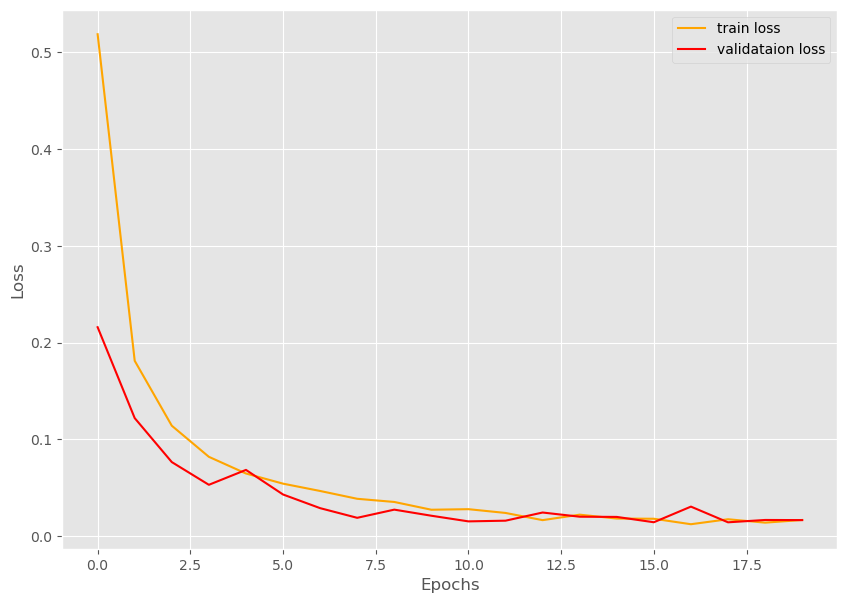

In [13]:
# Save the trained model weights.
save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss)